# Project 8 - Store Item Demand EDA and Forecasting

### Objective
* We are going to predict the store item sales number given a series of history data. For that data, we are going to use time series model to try to learn from the data. And please try to answer the following questions:
    1. How is the sales trend and growth rate over the 5 years?
    2. How is the sales trend by different stores?
    3. How is the sales trend by different items?
    4. Do you have any recommendations for the growth of the stores?
    5. Predict 3 months of sales for these 50 different items at 10 stores
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
import datetime
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import pickle

# Data Exploration

In this part, we get familar with the data by doing the following:
    * Check out the shape of data and the data types of each column
    * whether there is null or NAs
    * The unique values and their counts in each columns
in addition, we extract the 'year' and the 'month' feature from the column 'date' for the purpose of convience

In [2]:
pro_8 = pd.read_csv('/Users/qi/Desktop/DS /camp/Project 8/train.csv')
pro_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [3]:
pro_8.isnull().sum(), pro_8.isna().sum()

(date     0
 store    0
 item     0
 sales    0
 dtype: int64,
 date     0
 store    0
 item     0
 sales    0
 dtype: int64)

<AxesSubplot:>

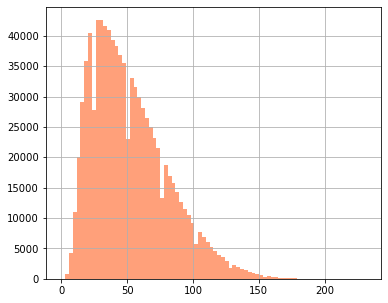

In [4]:
#pro_8_numcol = pd.DataFrame(pro_8, columns = pro_8.select_dtypes(include =['int']).columns)
pro_8['sales'].hist(figsize=(6,5),alpha = 1,color = '#FFA07A',bins = 80)

In [5]:
#time range
pro_8["date"].min(), pro_8["date"].max()

('2013-01-01', '2017-12-31')

In [6]:
#how many stores and items
pro_8.store.nunique(), pro_8.item.nunique()

(10, 50)

In [7]:
#sales range
pro_8['sales'].min(), pro_8['sales'].max()

(0, 231)

In [8]:
# how many items in each store
pro_8.groupby(['store'])['item'].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [9]:
#for i in pro_8.columns:
    #print(pro_8[i].value_counts())
    #print("-----------------------------------------")

In [10]:
pro_8.head(5)

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [11]:
pro = pro_8.iloc[:30,:]
pro['sales'].sum()

315

In [12]:
pro_8.shape

(913000, 4)

Extract 'year' and 'month' from 'date'

In [13]:
#df = data.copy()
pro_8['year'] = pro_8['date'].apply(lambda x: str(x)[:4])
pro_8['month'] = pro_8['date'].apply(lambda x: str(x)[:7])
pro_8

date  store  item  sales  year    month
0       2013-01-01      1     1     13  2013  2013-01
1       2013-01-02      1     1     11  2013  2013-01
2       2013-01-03      1     1     14  2013  2013-01
3       2013-01-04      1     1     13  2013  2013-01
4       2013-01-05      1     1     10  2013  2013-01
...            ...    ...   ...    ...   ...      ...
912995  2017-12-27     10    50     63  2017  2017-12
912996  2017-12-28     10    50     59  2017  2017-12
912997  2017-12-29     10    50     74  2017  2017-12
912998  2017-12-30     10    50     62  2017  2017-12
912999  2017-12-31     10    50     82  2017  2017-12

[913000 rows x 6 columns]

# 1 How is the sales trend and growth rate over the 5 years?

## Sales trend

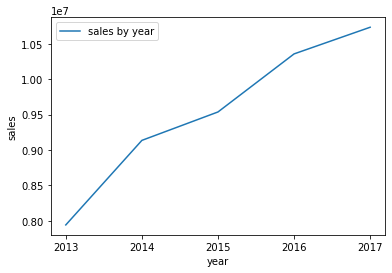

In [14]:
# Total Sales Trend By Year
x = list(pro_8.year.unique())
y_array = pro_8[['sales','year']].groupby('year').sum().values
y = [i for item in y_array for i in item]
y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
plt.plot(x,y,label='sales by year')
plt.legend()
plt.xlabel('year')
plt.ylabel('sales')
plt.show()

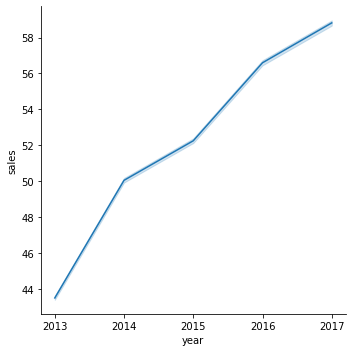

In [15]:
sns.relplot(kind ='line', data=pro_8, x='year', y='sales')

From the plot, we can see the sales trend is always growing over the 5 years and grows fastest during 2013 to 2014

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                   ...                        \
item          7          8          9          10  ...         41         42   
store                                              ...                         
1      52.783680  69.472070  46.504929  66.354326  ...  20.002738  33.105696   
2      75.058598  99.090361  65.478094  94.097481  ...  28.069551  47.368018   
3      66.647864  87.517525  58.486857  83.387733  ...  24.989047  41.797371   
4      61.625411  80.819825  54.043812  77.047645  ...  23.168127  38.539978   
5      44.535597  58.565717  38.837349  55.509858  ...  16.830778  27.730559   
6      44.599124  58.385542  39.460022  55.565170  ...  16.607338  27.893209   
7      40.709748  53.723987  35.901972  51.156627  ...  15.471522  25.435926   
8      71.730559  94.461117  63.193319  89.818182  ...  27.036145  45.144031   
9      61.812158  81.287514  54.105696  77.105148  ...  23.191128  38.643483   
10     65.807777  86.176889  57.886637  82.232202  ...  24.654984  41.222892   

                                                                          \
item          43         44          45         46         47         48   
store                                                                      
1      46.242607  26.594195   72.720701  52.845016  19.814348  46.546002   
2      65.785323  37.785871  103.381161  75.219606  28.187842  66.028478   
3      58.197700  33.386090   91.851041  66.748083  25.120482  58.700986   
4      54.018620  30.952355   84.687295  61.420044  23.114458  53.765608   
5      39.163198  22.415115   61.427163  44.734940  16.699343  39.281490   
6      39.034502  22.322563   61.142935  44.539978  16.708653  39.052574   
7      35.426068  20.446331   55.905805  40.828587  15.479189  35.624315   
8      62.980285  36.194414   98.941402  72.004929  27.150055  62.737130   
9      54.152793  30.968237   85.093647  62.010953  23.003286  53.976999   
10     57.942497  32.916758   90.690581  66.046550  24.755750  57.814896   

                             
item          49         50  
store                        
1      26.461665  59.342826  
2      37.711939  84.622125  
3      33.259584  74.958379  
4      30.840635  68.921687  
5      22.371851  50.319277  
6      22.181271  50.516429  
7      20.406353  45.823658  
8      36.035049  80.972070  
9      31.052574  69.308324  
10     33.032311  74.037240  

[10 rows x 50 columns]

<Figure size 1440x720 with 0 Axes>

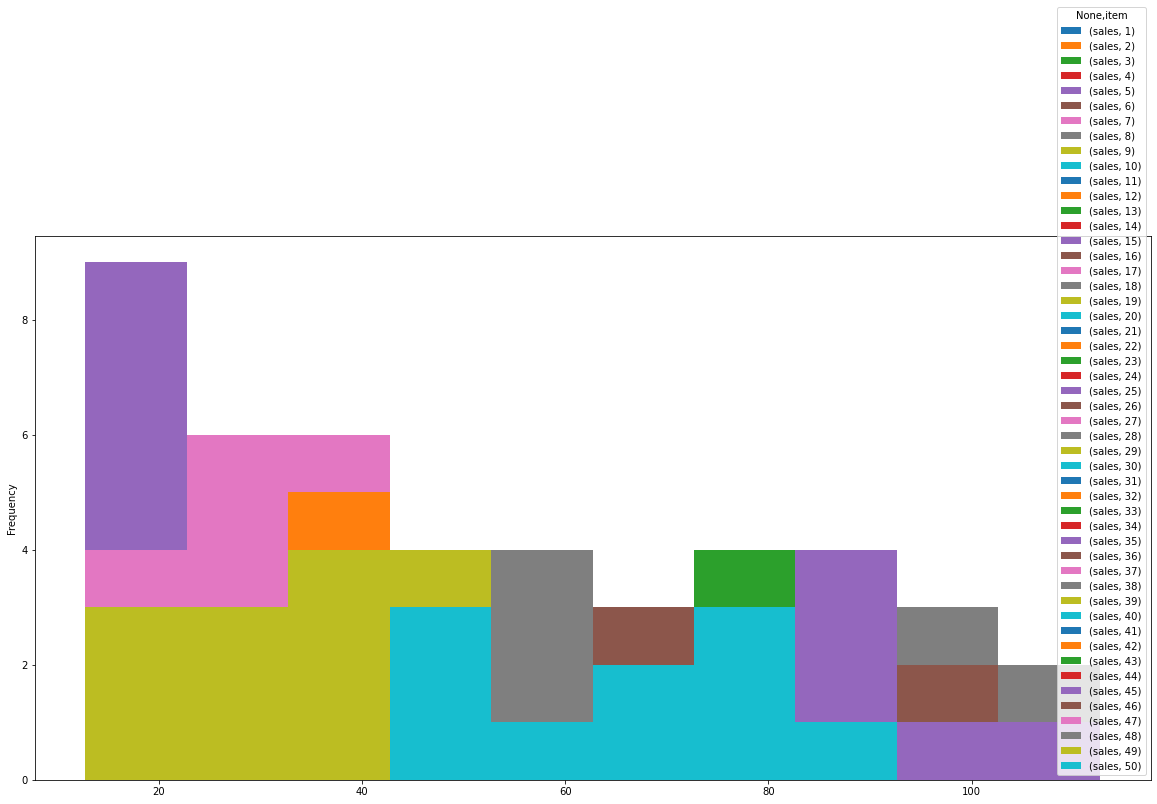

In [16]:
def sales_data_understanding(data):    
    store_df = data.copy()
    plt.figure(figsize=(20,10))
    sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
    sales_pivoted_df.plot(kind="hist",figsize=(20,10))
    # Pivoted dataframe
    display(sales_pivoted_df)
    return (store_df,sales_pivoted_df)

store_df,sales_pivoted_df = sales_data_understanding(pro_8)

In [84]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)
new_table = sales_across_store_df['avg_sale'].rename_axis('store').reset_index(name = 'avg_sale')
new_table.sort_values(by=['avg_sale'],ascending=False)

store   avg_sale
1      2  67.033165
7      8  64.142048
2      3  59.530602
9     10  58.709288
8      9  55.049025
3      4  54.902946
0      1  47.268379
4      5  39.770164
5      6  39.733516
6      7  36.363735

In [18]:
import plotly.graph_objs as go
import plotly.offline as py
#Scatter plot of average sales per store

sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

In [87]:
def sales_insight(sales_pivoted_df):
    # Let us calculate the average sales of each of the item across all the stores
    sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
    sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
    # And finally, sort by avg sale
    avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
    # Display the top 10 rows
    display(avg_sales_per_item_across_stores_df.head(10))
    return (sales_across_item_df,avg_sales_per_item_across_stores_df)

sales_across_item_df,avg_sales_per_item_across_stores_df = sales_insight(sales_pivoted_df)

item   avg_sale
14    15  88.030778
27    28  87.881325
12    13  84.316594
17    18  84.275794
24    25  80.686418
44    45  80.584173
37    38  80.521906
21    22  80.502245
35    36  77.028916
7      8  76.950055

In [20]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

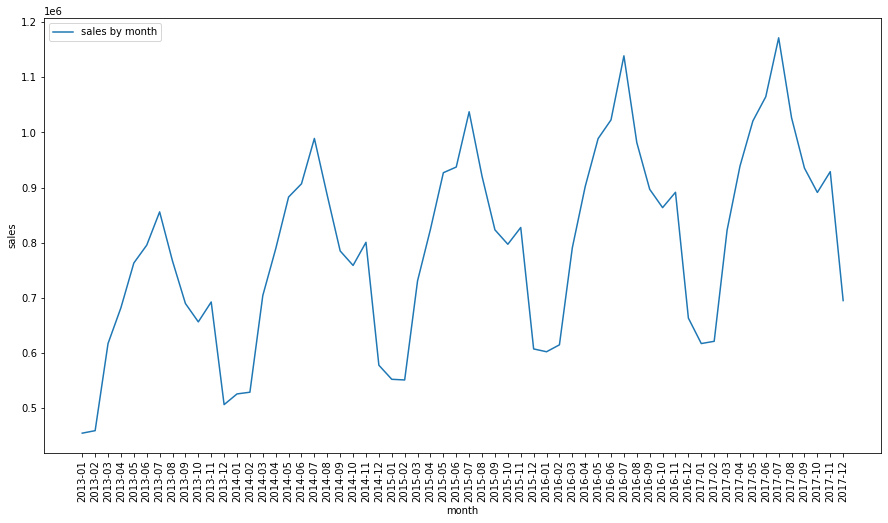

In [21]:
# Total Sales Trend By Month
x = list(pro_8['month'].unique())
y_array = pro_8[['sales','month']].groupby('month').sum().values
y = [i for item in y_array for i in item]
m_rate = []
for i in range(len(y)-1):
    m_rate.append(round(y[i+1]/y[i],3))
plt.figure(figsize=(15,8))
plt.plot(x,y,label='sales by month')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('month')
plt.ylabel('sales')
plt.show()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59],
 [Text(0, 0, '2013-01'),
  Text(1, 0, '2013-02'),
  Text(2, 0, '2013-03'),
  Text(3, 0, '2013-04'),
  Text(4, 0, '2013-05'),
  Text(5, 0, '2013-06'),
  Text(6, 0, '2013-07'),
  Text(7, 0, '2013-08'),
  Text(8, 0, '2013-09'),
  Text(9, 0, '2013-10'),
  Text(10, 0, '2013-11'),
  Text(11, 0, '2013-12'),
  Text(12, 0, '2014-01'),
  Text(13, 0, '2014-02'),
  Text(14, 0, '2014-03'),
  Text(15, 0, '2014-04'),
  Text(16, 0, '2014-05'),
  Text(17, 0, '2014-06'),
  Text(18, 0, '2014-07'),
  Text(19, 0, '2014-08'),
  Text(20, 0, '2014-09'),
  Text(21, 0, '2014-10'),
  Text(22, 0, '2014-11'),
  Text(23, 0, '2014-12'),
  Text(24, 0, '2015-01'),
  Text(25

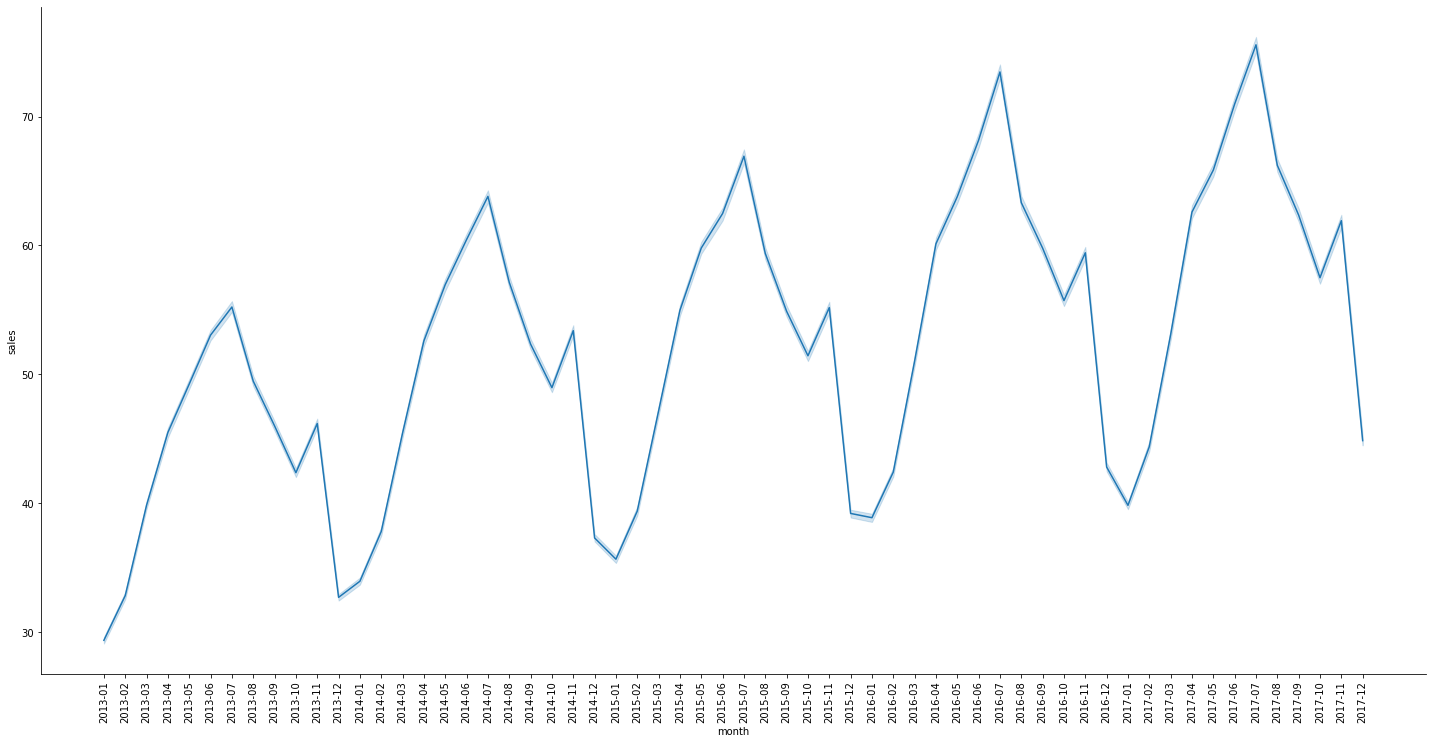

In [22]:
sns.relplot(kind ='line', data=pro_8, x='month', y='sales',height = 10, aspect = 2)
plt.xticks(rotation = 'vertical')

From the plot, we can see the sales is always highest of the year at July, which may caused by summer vacation. In addition, during November, there is a small peak caused by Thanks' Giving Day.

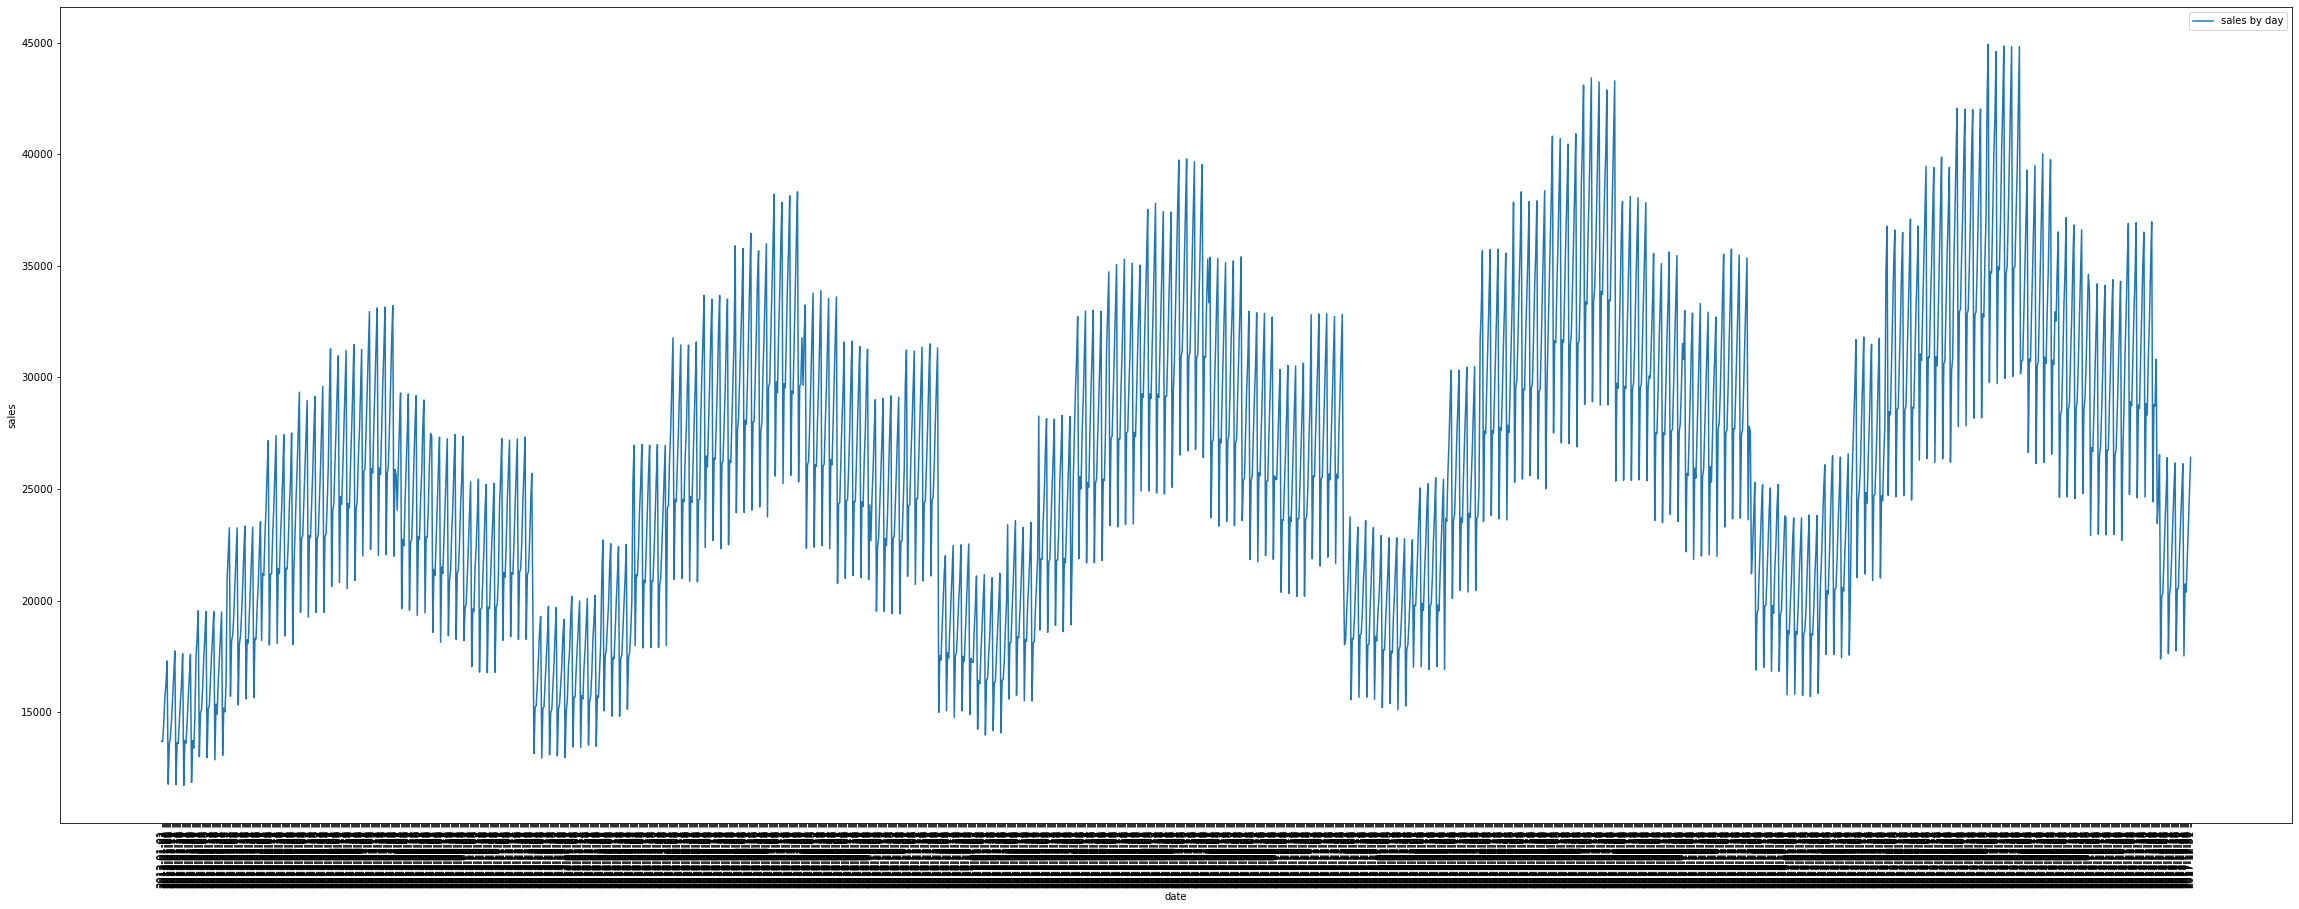

In [23]:
# Total Sales Trend By Date
x = list(pro_8['date'].unique())
y_array = pro_8[['sales','date']].groupby('date').sum().values
plt.figure(figsize=(40,15))
plt.plot(x,y_array,label='sales by day')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

## Growth rate

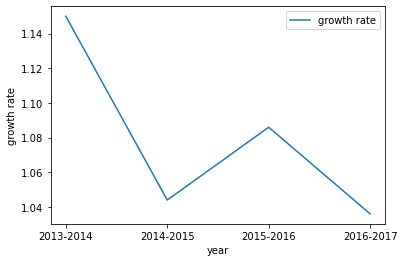

In [24]:
# Total Growth Rate By Year
# y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
plt.plot(['2013-2014','2014-2015','2015-2016','2016-2017'],y_rate,label='growth rate')
plt.legend()
plt.xlabel('year')
plt.ylabel('growth rate')
plt.show()

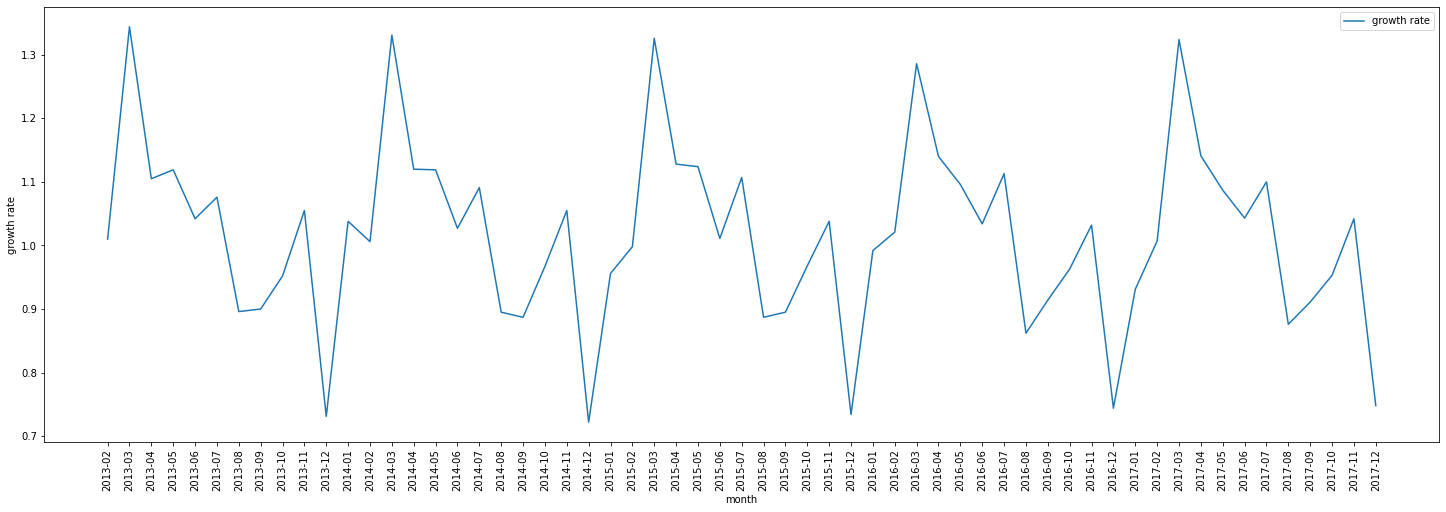

In [25]:
# Total Growth Rate By Month
plt.figure(figsize=(25,8))
plt.plot(list(pro_8['month'].unique())[1:],m_rate,label='growth rate')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('month')
plt.ylabel('growth rate')
plt.show()

# 2 How is the sales trend by different stores?

## Each line represents a store's sales trend over the 5 years

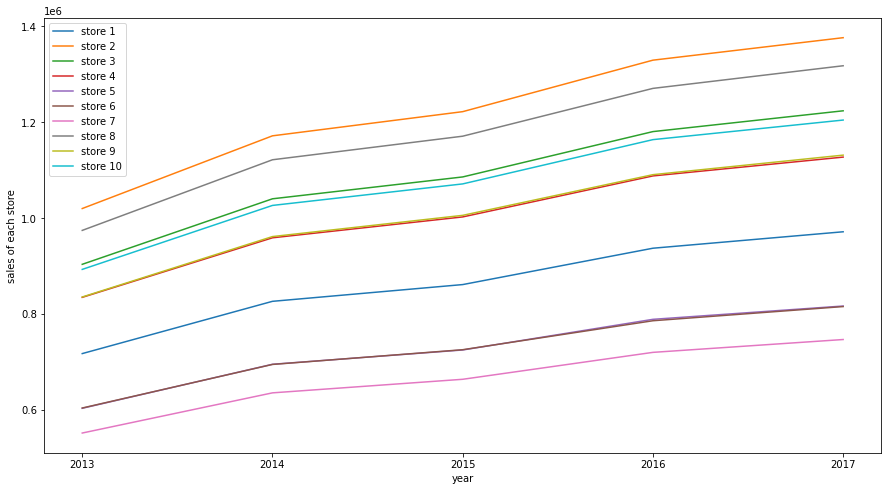

In [26]:
# Sales Trend For Each Store By Year
x = list(pro_8['year'].unique())
stores = list(pro_8['store'].unique())
y_growth_rate = {}
plt.figure(figsize=(15,8))
for i in stores:
    y_array = pro_8.loc[pro_8['store'] == i][['year','sales']].groupby('year').sum().values
    y = [i for item in y_array for i in item]
    y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
    y_growth_rate[i] = y_rate
    plt.plot(x,y,label = 'store '+ str(i))
plt.legend()
plt.xlabel('year')
plt.ylabel('sales of each store')
plt.show()

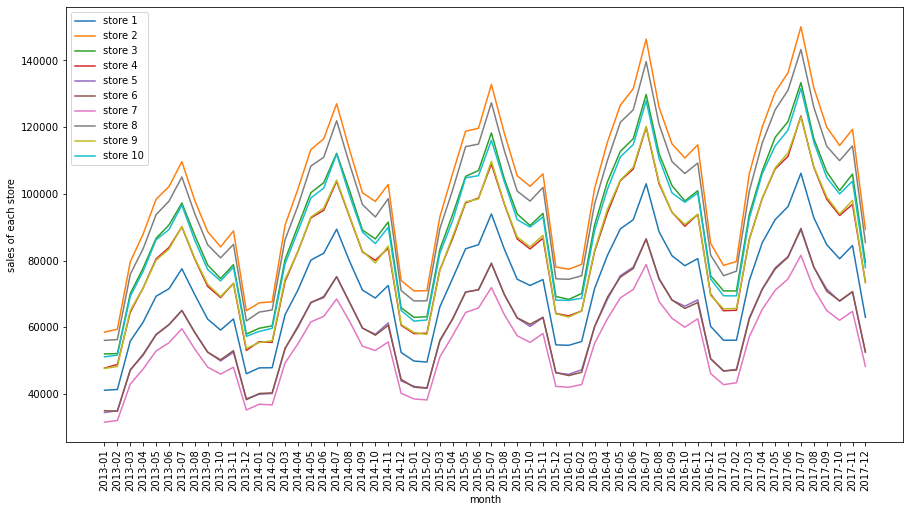

In [27]:
# Sales Trend For Each Store By Month
x = list(pro_8['month'].unique())
stores = list(pro_8['store'].unique())
m_growth_rate = {}
plt.figure(figsize=(15,8))
for i in stores:
    y_array = pro_8.loc[pro_8['store'] == i][['month','sales']].groupby('month').sum().values
    y = [i for item in y_array for i in item]
    m_rate = []
    for j in range(len(y)-1):
        m_rate.append(round(y[j+1]/y[j],3))
    m_growth_rate[i] = m_rate
    plt.plot(x,y,label = 'store '+ str(i))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('month')
plt.ylabel('sales of each store')
plt.show()

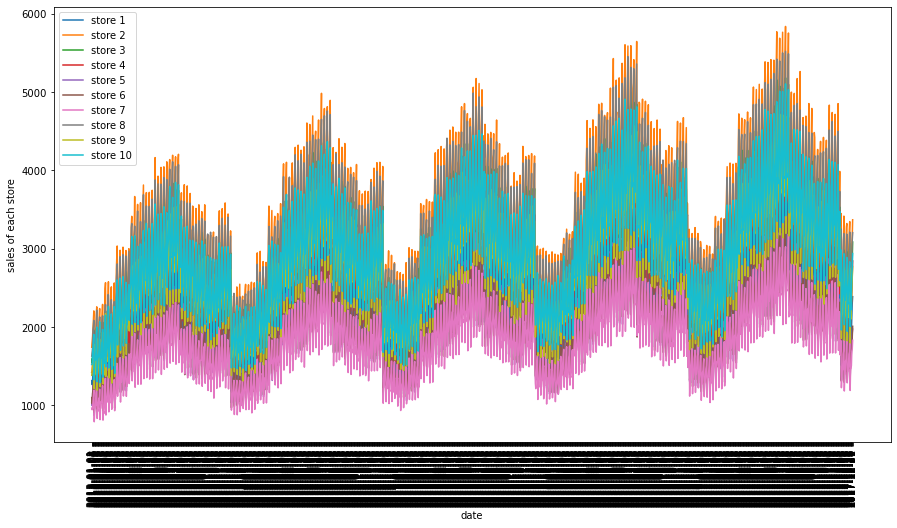

In [28]:
# Sales Trend For Each Store By Date
x = list(pro_8['date'].unique())
stores = list(pro_8['store'].unique())
plt.figure(figsize=(15,8))
for i in stores:
    y_array = pro_8.loc[pro_8['store'] == i][['date','sales']].groupby('date').sum().values
    y = [i for item in y_array for i in item]
    plt.plot(x,y,label = 'store '+ str(i))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('date')
plt.ylabel('sales of each store')
plt.show()

## Each row shows the growth rate of that store over the 5 years

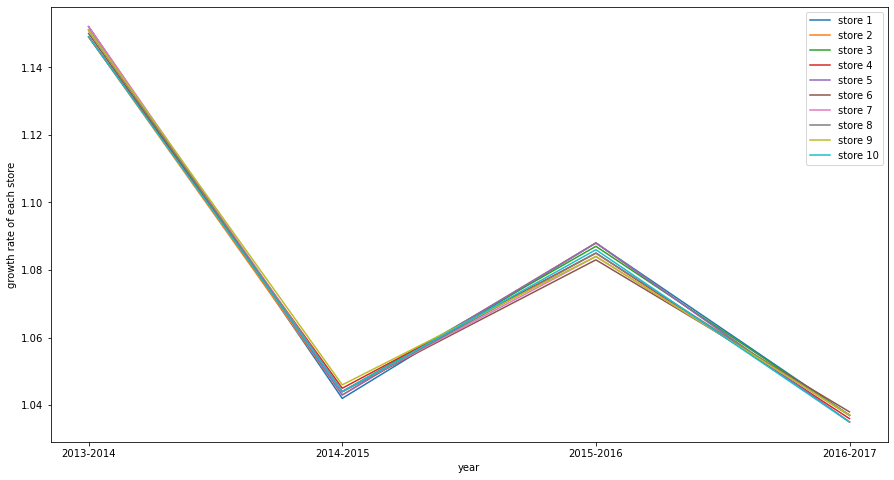

In [29]:
# Growth Rate For Each Store By Year
s_gr_df = pd.DataFrame(y_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns=['2013-2014','2014-2015','2015-2016','2016-2017'])

# plot
x = ['2013-2014','2014-2015','2015-2016','2016-2017']
plt.figure(figsize=(15,8))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'store '+ str(i))
plt.legend()
plt.xlabel('year')
plt.ylabel('growth rate of each store')
plt.show()

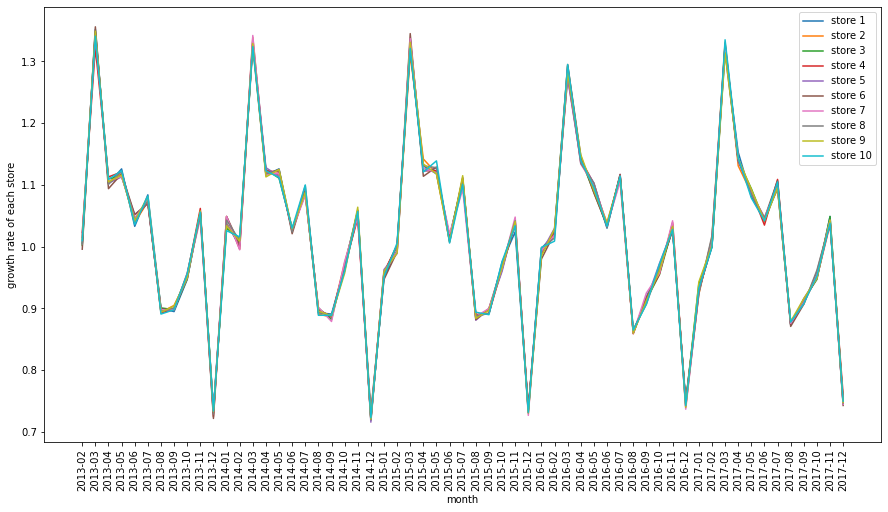

In [30]:
# Growth Rate For Each Store By Month
s_gr_df = pd.DataFrame(m_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns= list(pro_8['month'].unique())[1:])

# plot
x = list(pro_8['month'].unique())[1:]
plt.figure(figsize=(15,8))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'store '+ str(i))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('month')
plt.ylabel('growth rate of each store')
plt.show()

# 3 How is the sales trend by different items?

## Each line represents an item's sales trend over the 5 years

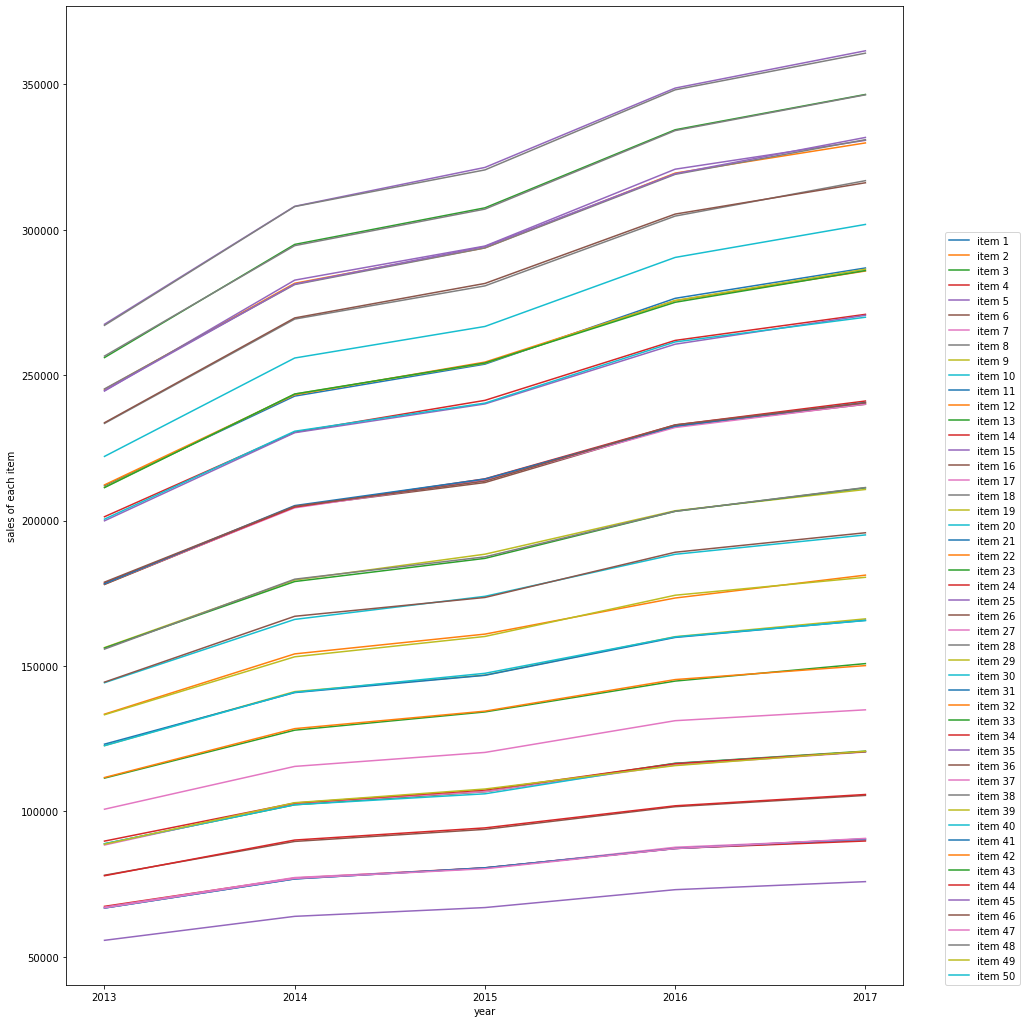

In [31]:
# Sales Trend For Each Item By Year
x = list(pro_8['year'].unique())
items = list(pro_8['item'].unique())
y_growth_rate = {}
plt.figure(figsize=(15,18))
for i in items:
    y_array = pro_8.loc[pro_8['item'] == i][['year','sales']].groupby('year').sum().values
    y = [i for item in y_array for i in item]
    y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
    y_growth_rate[i] = y_rate
    plt.plot(x,y,label = 'item '+ str(i))
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('year')
plt.ylabel('sales of each item')
plt.show()

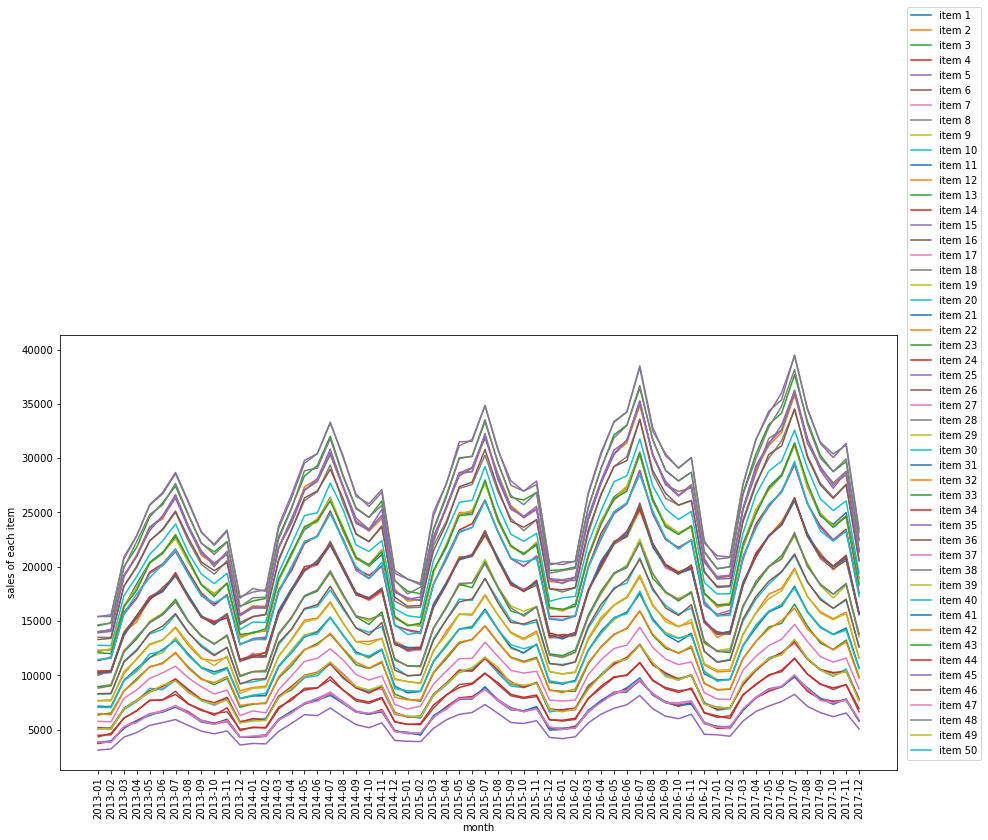

In [32]:
# Sales Trend For Each Item By Month
x = list(pro_8['month'].unique())
items = list(pro_8['item'].unique())
m_growth_rate = {}
plt.figure(figsize=(15,8))
for i in items:
    y_array = pro_8.loc[pro_8['item'] == i][['month','sales']].groupby('month').sum().values
    y = [i for item in y_array for i in item]
    m_rate = []
    for j in range(len(y)-1):
        m_rate.append(round(y[j+1]/y[j],3))
    m_growth_rate[i] = m_rate
    plt.plot(x,y,label = 'item '+ str(i))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=1)
plt.xlabel('month')
plt.ylabel('sales of each item')
plt.show()

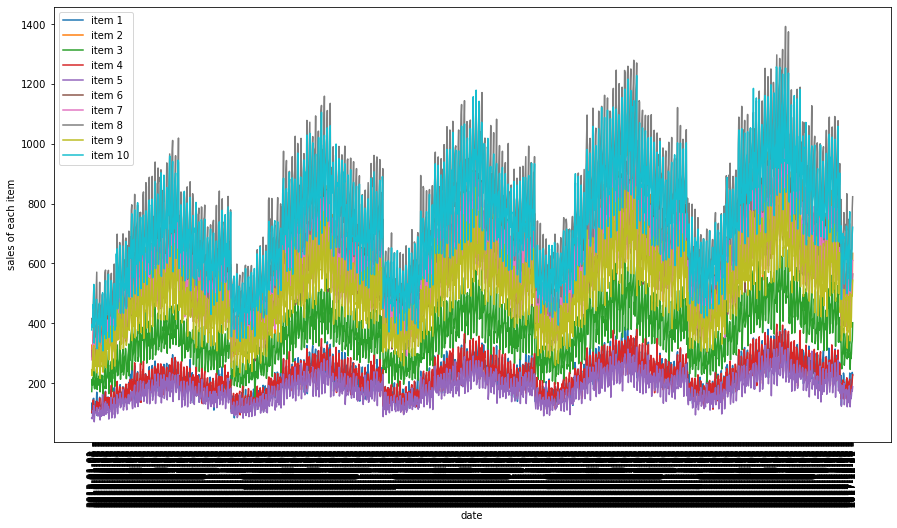

In [33]:
# Sales Trend For Each Item By Date
x = list(pro_8['date'].unique())
items = list(pro_8['item'].unique())
plt.figure(figsize=(15,8))
for i in stores:
    y_array = pro_8.loc[pro_8['item'] == i][['date','sales']].groupby('date').sum().values
    y = [i for item in y_array for i in item]
    plt.plot(x,y,label = 'item '+ str(i))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('date')
plt.ylabel('sales of each item')
plt.show()

## Each row shows the growth rate of that item over the 5 years

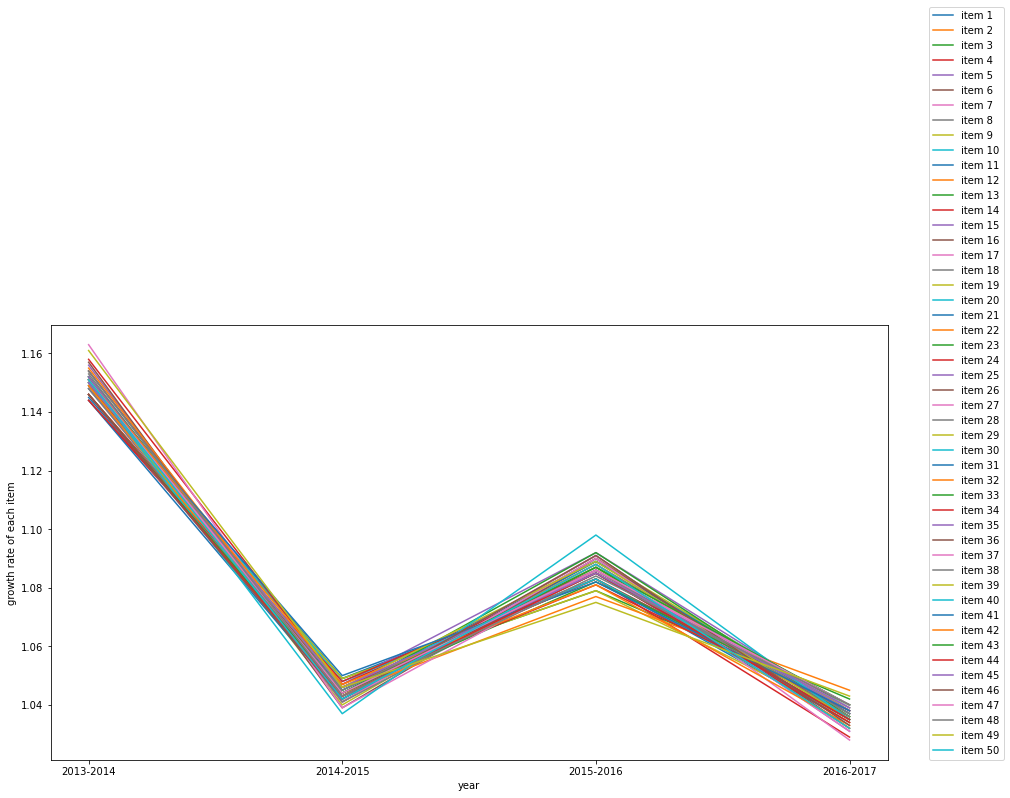

In [34]:
# Growth Rate For Each Item By Year
s_gr_df = pd.DataFrame(y_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns=['2013-2014','2014-2015','2015-2016','2016-2017'])

# plot
x = ['2013-2014','2014-2015','2015-2016','2016-2017']
plt.figure(figsize=(15,8))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'item '+ str(i))
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('year')
plt.ylabel('growth rate of each item')
plt.show()

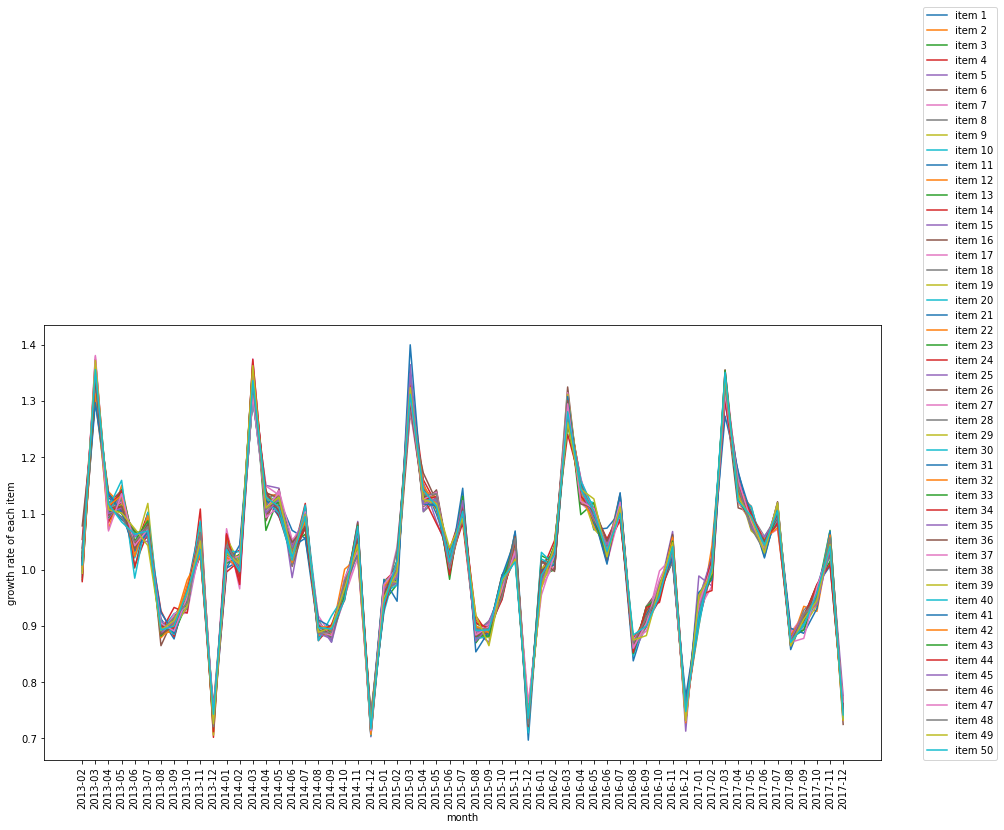

In [35]:
# Growth Rate For Each Item By Month
s_gr_df = pd.DataFrame(m_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns= list(pro_8['month'].unique())[1:])

# plot
x = list(pro_8['month'].unique())[1:]
plt.figure(figsize=(15,8))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'item '+ str(i))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('month')
plt.ylabel('growth rate of each item')
plt.show()

# 4 Do you have any recommendations for the growth of the stores?

All the 10 stores and the 50 items have similar sales trend, highest growth in 2015 compared to 2014, lower growth in 2015, then growth rate rises a little bit in 2016, but fall to lowest in 2017. This may indicates the growth is influenced by the whole economic environment and the market.
In addition, the time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the middle(festive season maybe) of the year and again low at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
For the stores, there may not much thing they can do. However, they can always find some way to make the sales growth become better, such as increasing sales opportunities, improving customer service, adding new products or product lines, etc.

# 5 Predict 3 months of sales for these 50 different items at 10 stores

In [52]:
pro_8_month = pro_8[['month','store','item','sales']].groupby(['month','store','item']).sum().reset_index()
pro_8_month

month  store  item  sales
0      2013-01      1     1    328
1      2013-01      1     2    911
2      2013-01      1     3    547
3      2013-01      1     4    346
4      2013-01      1     5    276
...        ...    ...   ...    ...
29995  2017-12     10    46   1723
29996  2017-12     10    47    626
29997  2017-12     10    48   1537
29998  2017-12     10    49    815
29999  2017-12     10    50   1987

[30000 rows x 4 columns]

## 5.1 Determining Stationarity

In [37]:
# singles_df = []
# for i in df_month['store'].values:
#     for j in df_month['item'].values:
#         monthly_single = df_month.loc[df_month['store'] == i].loc[df_month['item'] == j]
#         singles_df.append(monthly_single)

In [88]:
# create DataFrame for monthly sales
def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data


monthly_df = monthly_sales(pro_8)
monthly_df.head()

date   sales
0 2013-01-01  454904
1 2013-02-01  459417
2 2013-03-01  617382
3 2013-04-01  682274
4 2013-05-01  763242

/Users/qi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Users/qi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



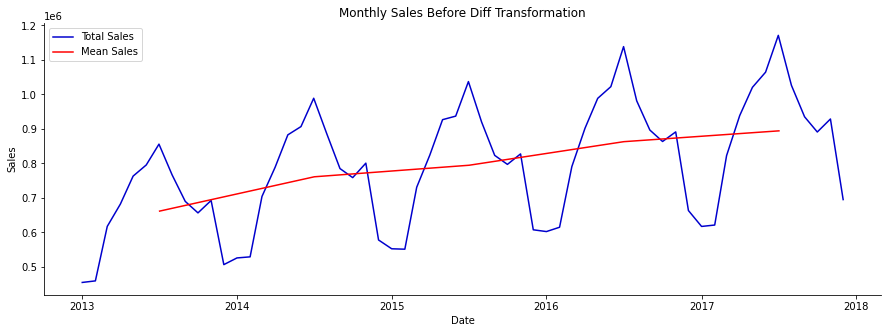

In [89]:
# Plot the sales of every month and mean of every year to determine stationary
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()
    
time_plot(monthly_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

The plot clearly shows that the sales is unstable, along with its obvious seasonality.

/Users/qi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Users/qi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



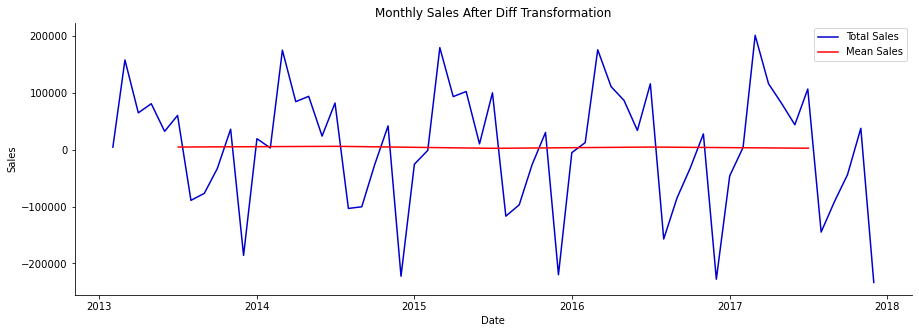

In [90]:
# Calculate the difference between every neighbor two months
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    return data

stationary_df = get_diff(monthly_df)
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

## 5.2 Feature Engineering

Now we can start building our feature set. We need to use previous monthly sales data to forecast the next ones. The look-back period (lag period) may vary for every model. Ours will be 12 for this example.

Different models may need different feature.

### 5.2.1 For Regressive Modeling

In [95]:
# Create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()

    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    return supervised_df


model_df = generate_supervised(stationary_df)
model_df.head()

date   sales  sales_diff     lag_1     lag_2     lag_3     lag_4  \
0 2014-02-01  529117      3130.0   19380.0 -186036.0   36056.0  -33320.0   
1 2014-03-01  704301    175184.0    3130.0   19380.0 -186036.0   36056.0   
2 2014-04-01  788914     84613.0  175184.0    3130.0   19380.0 -186036.0   
3 2014-05-01  882877     93963.0   84613.0  175184.0    3130.0   19380.0   
4 2014-06-01  906842     23965.0   93963.0   84613.0  175184.0    3130.0   

      lag_5     lag_6    lag_7    lag_8    lag_9   lag_10    lag_11    lag_12  
0  -76854.0  -89161.0  60325.0  32355.0  80968.0  64892.0  157965.0    4513.0  
1  -33320.0  -76854.0 -89161.0  60325.0  32355.0  80968.0   64892.0  157965.0  
2   36056.0  -33320.0 -76854.0 -89161.0  60325.0  32355.0   80968.0   64892.0  
3 -186036.0   36056.0 -33320.0 -76854.0 -89161.0  60325.0   32355.0   80968.0  
4   19380.0 -186036.0  36056.0 -33320.0 -76854.0 -89161.0   60325.0   32355.0

### 5.2.2 For ARIMA Modeling

In [57]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    return dt_data

arima_df = generate_arima_data(stationary_df)
arima_df

sales_diff
date                  
2013-02-01      4513.0
2013-03-01    157965.0
2013-04-01     64892.0
2013-05-01     80968.0
2013-06-01     32355.0
2013-07-01     60325.0
2013-08-01    -89161.0
2013-09-01    -76854.0
2013-10-01    -33320.0
2013-11-01     36056.0
2013-12-01   -186036.0
2014-01-01     19380.0
2014-02-01      3130.0
2014-03-01    175184.0
2014-04-01     84613.0
2014-05-01     93963.0
2014-06-01     23965.0
2014-07-01     82168.0
2014-08-01   -103414.0
2014-09-01   -100472.0
2014-10-01    -26241.0
2014-11-01     41900.0
2014-12-01   -222735.0
2015-01-01    -25535.0
2015-02-01     -1196.0
2015-03-01    179634.0
2015-04-01     93516.0
2015-05-01    102435.0
2015-06-01     10282.0
2015-07-01    100166.0
2015-08-01   -116949.0
2015-09-01    -97069.0
2015-10-01    -26079.0
2015-11-01     30392.0
2015-12-01   -220073.0
2016-01-01     -5133.0
2016-02-01     12518.0
2016-03-01    175924.0
2016-04-01    111069.0
2016-05-01     86780.0
2016-06-01     33934.0
2016-07-01    116054.0
2016-08-01   -157224.0
2016-09-01    -84663.0
2016-10-01    -33194.0
2016-11-01     27811.0
2016-12-01   -228037.0
2017-01-01    -46105.0
2017-02-01      4063.0
2017-03-01    201298.0
2017-04-01    116195.0
2017-05-01     81824.0
2017-06-01     43938.0
2017-07-01    106769.0
2017-08-01   -144990.0
2017-09-01    -91140.0
2017-10-01    -44103.0
2017-11-01     37677.0
2017-12-01   -233667.0

## 5.3 Modeling

In [58]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-3].values, data[-3:].values
    
    return train, test

train, test = tts(model_df)

### 5.3.1 Regressive model

In [59]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [60]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [61]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = data.copy()
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [62]:
def predict_df(unscaled_predictions, original_df):
    # create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-4:].date)
    act_sales = list(original_df[-4:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [63]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-3:], unscaled_df.pred_value[-3:]))
    mae = mean_absolute_error(original_df.sales[-3:], unscaled_df.pred_value[-3:])
    r2 = r2_score(original_df.sales[-3:], unscaled_df.pred_value[-3:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [64]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()

In [65]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

#### 5.3.1. a)  Linear Regression

In [66]:
run_model(train, test, LinearRegression(), 'LinearRegression')

AttributeError: 'list' object has no attribute 'date'

#### 5.3.1. b)  LSTM

In [ ]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

In [67]:
lstm_model(train, test)

NameError: name 'lstm_model' is not defined

In [68]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )

### 5.3.2 ARIMA Model  (SARIMAX)
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

* AR: Auto-Regressive (p): AR terms are just lags of dependent variable. For example lets say p is 3, we will use x(t-1), x(t-2) and x(t-3) to predict x(t)
* I: Integrated (d): These are the number of nonseasonal differences. 
* MA: Moving Averages (q): MA terms are lagged forecast errors in prediction equation.

In [ ]:
ts_data = arima_df.copy()
ts_data.index = pd.to_datetime(ts_data.index)

In [ ]:
def get_scores(data):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-3:], data.forecast[-3:]))
    mae = mean_absolute_error(data.sales_diff[-3:], data.forecast[-3:])
    r2 = r2_score(data.sales_diff[-3:], data.forecast[-3:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "arima_model_scores.p", "wb" ))

In [ ]:
# predict sales_diff and plot
def sarimax_model(data):

    
    # Model
    sar = sm.tsa.statespace.SARIMAX(ts_data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()
    # Predictions
    start, end, dynamic = pd.to_datetime('2017-10-01'),pd.to_datetime('2017-12-01'), False
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, ts_data, predictions = sarimax_model(ts_data)

In [ ]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = data.copy()
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-4:].date)
    act_sales = list(original_df[-4:].sales)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

In [ ]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()

In [ ]:
prediction_df, original_df = predict_df(predictions)
plot_results(prediction_df, original_df, 'arima')

We can also get dynamic predictions. One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

## 5.4 Model Selection

In [ ]:
def create_results_df():
    results_dict = pickle.load(open("model_scores.p", "rb"))
    
    results_dict.update(pickle.load(open("arima_model_scores.p", "rb")))
    
    restults_df = pd.DataFrame.from_dict(results_dict, orient='index', 
                                        columns=['RMSE', 'MAE','R2'])
    
    restults_df = restults_df.sort_values(by='RMSE', ascending=False).reset_index()
    
    return restults_df

In [ ]:
results = create_results_df()
results

In [ ]:
def plot_results(results_df):
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(np.arange(len(results_df)), 'RMSE', data=results_df, ax=ax, 
                 label='RMSE', color='mediumblue')
    sns.lineplot(np.arange(len(results_df)), 'MAE', data=results_df, ax=ax, 
                 label='MAE', color='Cyan')
    
    plt.xticks(np.arange(len(results_df)),rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel = "Model",
           ylabel = "Scores",
           title = "Model Error Comparison")
    sns.despine()
    

plot_results(results)